# Memory Impact from Checkpointing

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy as sp
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import DataLoader
from torch_scatter import scatter_add

from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric

from torch.utils.checkpoint import checkpoint

# Pick up local packages
sys.path.append('..')

# Local imports
from prepare_utils import *
from performance_utils import *
from toy_utils import *
from models import *
from trainers import *
%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import wandb
import faiss
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
torch_seed = 0

In [10]:
importlib.reload(sys.modules['toy_utils'])
from toy_utils import *

In [43]:
importlib.reload(sys.modules['models'])
from models import *

## Data Preparation

### Load Scrubbed Filter-ready Events

In [2]:
pt_cut = 0.5
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/"
basename = os.path.join(load_dir, str(pt_cut) + "_pt_cut")
train_path = os.path.join(basename, str(train_number) + "_events_train.pkl")
test_path = os.path.join(basename, str(test_number) + "_events_test.pkl")

In [3]:
%%time 
train_dataset = torch.load(train_path)
test_dataset = torch.load(test_path)
train_loader = DataLoader(train_dataset[:], batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset[:], batch_size=1, shuffle=True)

CPU times: user 171 ms, sys: 11.6 s, total: 11.8 s
Wall time: 15.3 s


## GNN Memory Tests

In [4]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation='Tanh',
                 layer_norm=True):
        super(EdgeNetwork, self).__init__()
        self.network = make_mlp(input_dim*2,
                                [hidden_dim, hidden_dim, hidden_dim, 1],
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, inputs):
        # Select the features of the associated nodes
        start, end = inputs[1]
        edge_inputs = torch.cat([inputs[0][start], inputs[0][end]], dim=1)
        return self.network(edge_inputs).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation='Tanh',
                 layer_norm=True):
        super(NodeNetwork, self).__init__()
        self.network = make_mlp(input_dim*3, [output_dim]*4,
                                hidden_activation=hidden_activation,
                                output_activation=None,
                                layer_norm=layer_norm)

    def forward(self, inputs):
        start, end = inputs[2]
        # Aggregate edge-weighted incoming/outgoing features
        mi = scatter_add(inputs[1][:, None] * inputs[0][start], end, dim=0, dim_size=inputs[0].shape[0])
        mo = scatter_add(inputs[1][:, None] * inputs[0][end], start, dim=0, dim_size=inputs[0].shape[0])
        node_inputs = torch.cat([mi, mo, inputs[0]], dim=1)
        return self.network(node_inputs)

class ResAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(ResAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(in_channels + hidden_dim, in_channels + hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(in_channels + hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        
    def forward(self, x, edge_index):
        """Apply forward pass of the model"""
        input_x = x
        x = self.input_network(x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, input_x], dim=-1)
#         print(x.shape)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            x_inital = x
            
            # Apply edge network
            e = torch.sigmoid(self.edge_network((x, edge_index)))
        
            # Apply node network
            x = self.node_network((x, e, edge_index))
            
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, input_x], dim=-1)  
            
            x = x_inital + x
        
        return self.edge_network((x, edge_index))


class CheckResAGNN(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, in_channels=3, hidden_dim=8, n_graph_iters=3,
                 hidden_activation=torch.nn.Tanh, layer_norm=True):
        super(CheckResAGNN, self).__init__()
        self.n_graph_iters = n_graph_iters
        # Setup the input network
        self.input_network = make_mlp(in_channels, [hidden_dim],
                                      output_activation=hidden_activation,
                                      layer_norm=layer_norm)
        # Setup the edge network
        self.edge_network = EdgeNetwork(in_channels + hidden_dim, in_channels + hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        # Setup the node layers
        self.node_network = NodeNetwork(in_channels + hidden_dim, hidden_dim,
                                        hidden_activation, layer_norm=layer_norm)
        self.dummy_tensor = torch.ones(1, dtype=torch.float32, requires_grad=True)
        
    def custom_forward(self, inputs):
        # Apply edge network
        print("x in check (before)", inputs[0], inputs[0].requires_grad)
        e = self.edge_network((inputs[0], inputs[1]))
        e = torch.sigmoid(e)
        x = self.node_network((inputs[0], e, inputs[1]))
        print("e in check", e, e.requires_grad)
        print("x in check (after)", x, x.requires_grad)
        # Apply node network
        return x
    
    def forward(self, x, edge_index):
        """Apply forward pass of the model"""
        input_x = x
        x = self.input_network(x)
        # Shortcut connect the inputs onto the hidden representation
        x = torch.cat([x, input_x], dim=-1)
#         print(x.shape)
        
        # Loop over iterations of edge and node networks
        for i in range(self.n_graph_iters):
            
            x_inital = x
            print("x before check", x, x.requires_grad)
            x = checkpoint(self.custom_forward, (x, edge_index, self.dummy_tensor))
#             x = self.custom_forward((x, edge_index))
            print("x after check", x, x.requires_grad)
#             x.requires_grad_(True)
            # Apply edge network
#             e = checkpoint(self.edge_network, (x, edge_index))
#             e = self.edge_network((x, edge_index))
#             e = torch.sigmoid(e)
        
            # Apply node network
#             x = checkpoint(self.node_network, (x, e, edge_index))
#             x = self.node_network((x, e, edge_index))
            
            # Shortcut connect the inputs onto the hidden representation
            x = torch.cat([x, input_x], dim=-1)  
            
            x = x_inital + x
            
        e = self.edge_network((x, edge_index))
#         e = torch.sigmoid(e)
        
        return e
    
class MPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(MPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, x, edge_index):

        # Encode the graph features into the hidden space
        x = self.node_encoder(x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
            e = self.edge_network(edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, edge_index[1], dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = self.node_network(node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return self.edge_classifier(clf_inputs).squeeze(-1)
    
class CheckMPNN_Network(nn.Module):
    """
    A message-passing graph network which takes a graph with:
    - bi-directional edges
    - node features, no edge features

    and applies the following modules:
    - a graph encoder (no message passing)
    - recurrent edge and node networks
    - an edge classifier
    """

    def __init__(self, input_dim, hidden_node_dim, hidden_edge_dim, in_layers, node_layers, edge_layers,
                 n_graph_iters=1, layer_norm=True):
        super(CheckMPNN_Network, self).__init__()
        self.n_graph_iters = n_graph_iters

        # The node encoder transforms input node features to the hidden space
        self.node_encoder = make_mlp(input_dim, [hidden_node_dim]*in_layers)

        # The edge network computes new edge features from connected nodes
        self.edge_network = make_mlp(2*hidden_node_dim,
                                     [hidden_edge_dim]*edge_layers,
                                     layer_norm=layer_norm)

        # The node network computes new node features
        self.node_network = make_mlp(hidden_node_dim + hidden_edge_dim,
                                     [hidden_node_dim]*node_layers,
                                     layer_norm=layer_norm)

        # The edge classifier computes final edge scores
        self.edge_classifier = make_mlp(2*hidden_node_dim,
                                        [hidden_edge_dim, 1],
                                        output_activation=None)

    def forward(self, x, edge_index):

        # Encode the graph features into the hidden space
        x = self.node_encoder(x)

        # Loop over graph iterations
        for i in range(self.n_graph_iters):

            # Previous hidden state
            x0 = x

            # Compute new edge features
            edge_inputs = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
            e = checkpoint(self.edge_network, edge_inputs)

            # Sum edge features coming into each node
            aggr_messages = scatter_add(e, edge_index[1], dim=0, dim_size=x.shape[0])

            # Compute new node features
            node_inputs = torch.cat([x, aggr_messages], dim=1)
            x = checkpoint(self.node_network, node_inputs)

            # Residual connection
            x = x + x0

        # Compute final edge scores; use original edge directions only
        start_idx, end_idx = edge_index
        clf_inputs = torch.cat([x[start_idx], x[end_idx]], dim=1)
        return checkpoint(self.edge_classifier, clf_inputs).squeeze(-1)

In [5]:
class Filter(torch.nn.Module):
    def __init__(self, in_channels, emb_channels, hidden, nb_layer):
        super(Filter, self).__init__()
        self.input_layer = Linear(in_channels*2 + emb_channels*2, hidden)
        layers = [Linear(hidden, hidden) for _ in range(nb_layer-1)]
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(hidden, 1)
        self.norm = nn.LayerNorm(hidden)
        self.act = nn.Tanh()

    def forward(self, x, e, emb=None):
        if emb is not None:
            x = self.input_layer(torch.cat([x[e[0]], emb[e[0]], x[e[1]], emb[e[1]]], dim=-1))
        else:
            x = self.input_layer(torch.cat([x[e[0]], x[e[1]]], dim=-1))
        for l in self.layers:
            x = l(x)
            x = self.act(x)
#         x = self.norm(x) #Option of LayerNorm
        x = self.output_layer(x)
        return x

In [5]:
def train_gnn(model, train_loader, optimizer, m_configs):
    
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        if m_configs['ratio'] != 0:
            num_true = batch.y.sum()
            fake_indices = np.random.choice(np.where(~batch.y.bool())[0], int(num_true*m_configs['ratio']), replace=True)
            true_indices = np.where(batch.y.bool())[0]
            combined_indices = np.concatenate([true_indices, fake_indices])

            x, e = batch.x.to(device), batch.e_radius[:,combined_indices].to(device)
            weight = torch.tensor(m_configs['ratio'])
            combined_y = batch.y[combined_indices]   
        
        else:
            x, e = batch.x.to(device), batch.e_radius.to(device)
            weight = torch.tensor((~batch.y.bool()).sum() / batch.y.sum())
            combined_y = batch.y         
        
        output = model(x, e).squeeze()
        
        y_pid = (batch.pid[batch.e_radius[0]] == batch.pid[batch.e_radius[1]]).float()
                
#         loss = F.binary_cross_entropy_with_logits(output.cpu(), combined_y, pos_weight = weight)
        loss = F.binary_cross_entropy_with_logits(output.cpu(), y_pid, pos_weight = torch.tensor(3))
        total_loss += loss.item()
#         print(i, loss)
        loss.backward()
        optimizer.step()
    
    return total_loss

def evaluate_gnn(model, test_loader, m_configs):
    
    edge_true, edge_true_positive, edge_positive, edge_total_positive, edge_total_true, edge_total_true_positive = [0]*6
    total_loss = 0
    
    for i, batch in enumerate(test_loader):
            
#         subset_ind = np.random.choice(np.arange(0, batch.e_radius.shape[1]), int(m_configs['test_subset']*batch.e_radius.shape[1]), replace=False)
        if m_configs['ratio'] != 0:
            subset_ind = np.random.randint(0, batch.e_radius.shape[1], 10000)
        else:
            subset_ind = np.arange(0, batch.e_radius.shape[1])
        x, e = batch.x.to(device), batch.e_radius[:, subset_ind].to(device)
        output = model(x, e).squeeze()
        
        y_pid = (batch.pid[batch.e_radius[0]] == batch.pid[batch.e_radius[1]]).float()
        
#         loss = F.binary_cross_entropy_with_logits(output.cpu(), batch.y[subset_ind])
        loss = F.binary_cross_entropy_with_logits(output.cpu(), y_pid)
        total_loss += loss.item()
        
        preds = F.sigmoid(output.cpu()) > 0.5
        
        #Edge filter performance
#         edge_true = batch.y[subset_ind].sum()
        edge_true = y_pid.sum()
#         edge_true_positive = (batch.y[subset_ind].bool() & preds).sum()
        edge_true_positive = (y_pid.bool() & preds).sum()
        edge_positive = preds.sum()
        
        edge_total_true_positive += edge_true_positive
        edge_total_positive += edge_positive
        edge_total_true += edge_true
        
#         print("True positive:", edge_true_positive, "True:", edge_true, "Positive:", edge_positive)

    edge_eff = edge_total_true_positive.float() / max(edge_total_true.float(), 1)
    edge_pur = edge_total_true_positive.float() / max(edge_total_positive.float(), 1)

    return edge_pur, edge_eff, total_loss


### Benchmark Tests

In [6]:
torch.manual_seed(0)

# m_configs = {"in_channels": 3, "hidden_dim": 32, "n_graph_iters": 6}
# model = ResAGNN(**m_configs).to(device)

m_configs = {"input_dim": 3, "hidden_node_dim": 64, "hidden_edge_dim": 128, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 8, "layer_norm": True}
model = MPNN_Network(**m_configs).to(device)

other_configs = {'ratio': 0, 'test_subset': 0.001}
m_configs.update(other_configs)
model_name = wandb.init(project="CheckpointExploration", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

torch.cuda.reset_max_memory_allocated()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
model.train()

total_loss = 0
tic = tt()
for i, batch in enumerate(train_loader):
    optimizer.zero_grad()

    if m_configs['ratio'] != 0:
        num_true = batch.y.sum()
        fake_indices = np.random.choice(np.where(~batch.y.bool())[0], int(num_true*m_configs['ratio']), replace=True)
        true_indices = np.where(batch.y.bool())[0]
        combined_indices = np.concatenate([true_indices, fake_indices])

        x, e = batch.x.to(device), batch.e_radius[:,combined_indices].to(device)
        weight = torch.tensor(m_configs['ratio'])
        combined_y = batch.y[combined_indices]   

    else:
        x, e = batch.x.to(device), batch.e_radius.to(device)
        weight = torch.tensor((~batch.y.bool()).sum() / batch.y.sum())
        combined_y = batch.y         
    x.requires_grad_(True)
    
    output = model(x, e)

    loss = F.binary_cross_entropy_with_logits(output, combined_y.to(device), pos_weight = weight)
    total_loss += loss.item()
#         print(i, loss)
    loss.backward()
    optimizer.step()
    
    break
print("Memory max (GB):", torch.cuda.max_memory_allocated() / 1024**3, "- time:", tt()-tic)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Memory max (GB): 9.888021469116211 - time: 1.5440750122070312


In [61]:
output_not_checkpointed = output.data.clone()
grad_not_checkpointed = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_not_checkpointed[name] = param.grad.data.clone()
    else:
        print(name, "is NONE!")

In [65]:
output_not_checkpointed

tensor([0.6636, 0.6636, 0.6636,  ..., 0.9206, 1.1540, 1.1405], device='cuda:0')

In [66]:
output_checkpointed

tensor([0.6636, 0.6636, 0.6636,  ..., 0.9206, 1.1540, 1.1405], device='cuda:0')

In [67]:
grad_not_checkpointed

{'node_encoder.0.weight': tensor([[-7.4650e-04, -8.5498e-04,  8.2160e-04],
         [ 1.0996e-03, -7.5045e-03, -3.9679e-04],
         [ 6.0399e-05,  2.7517e-04, -3.9528e-05],
         [-8.7073e-05,  3.9059e-05,  4.5261e-05],
         [-3.1462e-06,  2.7884e-05,  3.5855e-06],
         [-4.9015e-04,  2.0558e-03,  5.0035e-04],
         [ 3.6316e-06, -1.3667e-05,  1.3668e-05],
         [-1.5317e-03,  4.7140e-03, -1.2496e-03],
         [-2.7532e-03, -1.6618e-03, -2.5133e-03],
         [ 2.3405e-03,  1.3391e-03, -1.2645e-03],
         [ 6.8052e-05, -4.7394e-04, -6.6557e-05],
         [ 1.7535e-04, -5.0981e-04, -2.7442e-04],
         [ 3.4337e-04,  2.8137e-03,  1.4704e-04],
         [-5.5038e-03, -7.2412e-04, -8.1829e-04],
         [-8.1277e-04,  7.7152e-04,  6.8225e-04],
         [ 2.6660e-03,  9.2370e-04, -1.0801e-03],
         [-8.9833e-05,  6.8392e-03, -8.2161e-04],
         [ 2.9409e-03, -1.0832e-03, -1.2232e-03],
         [-2.9338e-03,  6.9049e-03,  1.4955e-03],
         [-7.8155e-04,  4

In [68]:
grad_checkpointed

{'node_encoder.0.weight': tensor([[-7.4650e-04, -8.5498e-04,  8.2160e-04],
         [ 1.0996e-03, -7.5044e-03, -3.9677e-04],
         [ 6.0400e-05,  2.7517e-04, -3.9527e-05],
         [-8.7072e-05,  3.9058e-05,  4.5261e-05],
         [-3.1462e-06,  2.7884e-05,  3.5855e-06],
         [-4.9014e-04,  2.0558e-03,  5.0034e-04],
         [ 3.6316e-06, -1.3667e-05,  1.3668e-05],
         [-1.5317e-03,  4.7140e-03, -1.2496e-03],
         [-2.7531e-03, -1.6618e-03, -2.5133e-03],
         [ 2.3405e-03,  1.3391e-03, -1.2645e-03],
         [ 6.8052e-05, -4.7394e-04, -6.6557e-05],
         [ 1.7535e-04, -5.0981e-04, -2.7442e-04],
         [ 3.4337e-04,  2.8137e-03,  1.4704e-04],
         [-5.5038e-03, -7.2406e-04, -8.1829e-04],
         [-8.1278e-04,  7.7152e-04,  6.8226e-04],
         [ 2.6660e-03,  9.2366e-04, -1.0801e-03],
         [-8.9837e-05,  6.8392e-03, -8.2161e-04],
         [ 2.9409e-03, -1.0832e-03, -1.2232e-03],
         [-2.9338e-03,  6.9049e-03,  1.4955e-03],
         [-7.8155e-04,  4

In [90]:
print("Memory max (GB):", torch.cuda.max_memory_allocated() / 1024**3)

Memory max (GB): 1.2986721992492676


### Checkpointed Tests

In [12]:
torch.manual_seed(0)

# m_configs = {"in_channels": 3, "hidden_dim": 32, "n_graph_iters": 6}
# model = CheckResAGNN(**m_configs).to(device)

m_configs = {"input_dim": 3, "hidden_node_dim": 64, "hidden_edge_dim": 128, "in_layers": 2, "node_layers": 4, "edge_layers": 4, "n_graph_iters": 8, "layer_norm": True}
model = CheckMPNN_Network(**m_configs).to(device)

other_configs = {'ratio': 0, 'test_subset': 0.001}
m_configs.update(other_configs)
model_name = wandb.init(project="CheckpointExploration", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

torch.cuda.reset_max_memory_allocated()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [11]:
model.train()

total_loss = 0
tic = tt()
for i, batch in enumerate(train_loader):
    optimizer.zero_grad()

    if m_configs['ratio'] != 0:
        num_true = batch.y.sum()
        fake_indices = np.random.choice(np.where(~batch.y.bool())[0], int(num_true*m_configs['ratio']), replace=True)
        true_indices = np.where(batch.y.bool())[0]
        combined_indices = np.concatenate([true_indices, fake_indices])

        x, e = batch.x.to(device), batch.e_radius[:,combined_indices].to(device)
        weight = torch.tensor(m_configs['ratio'])
        combined_y = batch.y[combined_indices]   

    else:
        x, e = batch.x.to(device), batch.e_radius.to(device)
        weight = torch.tensor((~batch.y.bool()).sum() / batch.y.sum())
        combined_y = batch.y         
#     x.requires_grad_(True)
    output = model(x, e)
    
    loss = F.binary_cross_entropy_with_logits(output, combined_y.to(device), pos_weight = weight)
    total_loss += loss.item()
#         print(i, loss)
    loss.backward()
    
#     output.mean().backward()
    optimizer.step()
    
    break
print("Memory max (GB):", torch.cuda.max_memory_allocated() / 1024**3, "- time:", tt()-tic)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Memory max (GB): 6.213899612426758 - time: 1.9646477699279785


In [64]:
output_checkpointed = output.data.clone()
grad_checkpointed = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_checkpointed[name] = param.grad.data.clone()
    else:
        print(name, "is NONE!")

In [48]:
for k, v in model.named_parameters():
    print(v.grad)

tensor([[ 3.4827e-04, -1.6849e-04,  1.6293e-04],
        [-6.9217e-04,  1.0137e-06, -1.5192e-05],
        [-1.1422e-03, -4.9120e-04,  5.0173e-04],
        [-2.0882e-03,  4.6678e-04,  8.0273e-04],
        [-5.8277e-04,  1.0323e-04, -4.9846e-04],
        [ 7.3378e-04, -1.2949e-03, -4.7639e-04],
        [-2.6608e-04,  4.2600e-04,  8.8583e-04],
        [ 4.6850e-03, -4.5987e-04, -3.0314e-03],
        [-3.4472e-04,  7.9671e-05,  1.2699e-04],
        [-3.2708e-03,  9.7536e-04,  1.4880e-03],
        [-2.8194e-04, -1.3201e-04,  3.0481e-04],
        [ 1.3466e-03, -1.3849e-03, -1.1392e-03],
        [-1.3290e-03, -4.9063e-04,  1.2931e-03],
        [ 9.5799e-04,  2.1863e-04,  1.8548e-04],
        [ 3.1812e-03, -1.8188e-04, -1.8478e-03],
        [-4.5667e-04, -6.9510e-04,  7.0827e-04],
        [-1.4299e-03,  2.7700e-04,  4.7499e-04],
        [-1.9144e-04, -1.1173e-04,  4.4829e-05],
        [ 3.4400e-04,  1.4163e-04, -6.3307e-05],
        [ 3.8257e-04,  2.5238e-05, -5.2217e-04],
        [-1.1863e-03

### Memory Grid Scan

Want to scan over MP iterations, network size (width), and MLP layers.

In [17]:
layer_set = 1, 7, 1
iteration_set = 1, 9, 1
channel_set = 8, 128, 8

In [18]:
def train_step(input_data, model, optimizer):
    optimizer.zero_grad()

    x, e = input_data.x.to(device), input_data.e_radius.to(device)
    weight = torch.tensor((~input_data.y.bool()).sum() / input_data.y.sum())
    combined_y = input_data.y         
    x.requires_grad_(True)

    output = model(x, e)

    loss = F.binary_cross_entropy_with_logits(output, combined_y.to(device), pos_weight = weight)
    loss.backward()
    optimizer.step()

In [19]:
input_data = train_dataset[0]

In [20]:
%%time
memory_uncheck = np.empty(((layer_set[1] - layer_set[0])//layer_set[2], (iteration_set[1] - iteration_set[0])//iteration_set[2], (channel_set[1] - channel_set[0])//channel_set[2]))
memory_check = np.empty(((layer_set[1] - layer_set[0])//layer_set[2], (iteration_set[1] - iteration_set[0])//iteration_set[2], (channel_set[1] - channel_set[0])//channel_set[2]))
time_uncheck = np.empty(((layer_set[1] - layer_set[0])//layer_set[2], (iteration_set[1] - iteration_set[0])//iteration_set[2], (channel_set[1] - channel_set[0])//channel_set[2]))
time_check = np.empty(((layer_set[1] - layer_set[0])//layer_set[2], (iteration_set[1] - iteration_set[0])//iteration_set[2], (channel_set[1] - channel_set[0])//channel_set[2]))


for i, layers in enumerate(np.arange(*layer_set)):
    for j, iterations in enumerate(np.arange(*iteration_set)):
        for k, channels in enumerate(np.arange(*channel_set)):
            
            torch.cuda.reset_max_memory_allocated()
            torch.manual_seed(0)

            m_configs = {"input_dim": 3, "hidden_node_dim": channels, "hidden_edge_dim": channels, "in_layers": layers, "node_layers": layers, "edge_layers": layers, "n_graph_iters": iterations, "layer_norm": True}
            model = MPNN_Network(**m_configs).to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
            
            tic = tt()
            train_step(input_data, model, optimizer)
            tic_uncheck = tt() - tic
            time_uncheck[i, j, k] = tic_uncheck
            max_mem_uncheck = torch.cuda.max_memory_allocated() / 1024**3
            memory_uncheck[i, j, k] = max_mem_uncheck
            
                        
            torch.cuda.reset_max_memory_allocated()
            torch.manual_seed(0)
            
            model = CheckMPNN_Network(**m_configs).to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
            
            tic = tt()
            train_step(input_data, model, optimizer)
            tic_check = tt() - tic
            time_check[i, j, k] = tic_check
            max_mem_check = torch.cuda.max_memory_allocated() / 1024**3
            memory_check[i, j, k] = max_mem_check
            print("Step:", (i, j, k), "- Memory (unchecked):", max_mem_uncheck, "(checked):", max_mem_check)

Step: (0, 0, 0) - Memory (unchecked): 0.052761077880859375 (checked): 0.042510032653808594
Step: (0, 0, 1) - Memory (unchecked): 0.0982823371887207 (checked): 0.07532596588134766
Step: (0, 0, 2) - Memory (unchecked): 0.1424570083618164 (checked): 0.11077594757080078
Step: (0, 0, 3) - Memory (unchecked): 0.18483495712280273 (checked): 0.14318609237670898
Step: (0, 0, 4) - Memory (unchecked): 0.23148393630981445 (checked): 0.17937326431274414
Step: (0, 0, 5) - Memory (unchecked): 0.27626466751098633 (checked): 0.21467828750610352
Step: (0, 0, 6) - Memory (unchecked): 0.31953907012939453 (checked): 0.2479839324951172
Step: (0, 0, 7) - Memory (unchecked): 0.36278867721557617 (checked): 0.2812657356262207
Step: (0, 0, 8) - Memory (unchecked): 0.40828561782836914 (checked): 0.3166670799255371
Step: (0, 0, 9) - Memory (unchecked): 0.4533967971801758 (checked): 0.35193634033203125
Step: (0, 0, 10) - Memory (unchecked): 0.4968748092651367 (checked): 0.38544559478759766
Step: (0, 0, 11) - Memory

Step: (0, 6, 4) - Memory (unchecked): 0.8402466773986816 (checked): 0.4798579216003418
Step: (0, 6, 5) - Memory (unchecked): 1.0020160675048828 (checked): 0.573544979095459
Step: (0, 6, 6) - Memory (unchecked): 1.1703782081604004 (checked): 0.6690316200256348
Step: (0, 6, 7) - Memory (unchecked): 1.3316445350646973 (checked): 0.7615370750427246
Step: (0, 6, 8) - Memory (unchecked): 1.4936528205871582 (checked): 0.8561854362487793
Step: (0, 6, 9) - Memory (unchecked): 1.6599431037902832 (checked): 0.950045108795166
Step: (0, 6, 10) - Memory (unchecked): 1.821507453918457 (checked): 1.044668197631836
Step: (0, 6, 11) - Memory (unchecked): 1.9821491241455078 (checked): 1.1355342864990234
Step: (0, 6, 12) - Memory (unchecked): 2.150423049926758 (checked): 1.2340269088745117
Step: (0, 6, 13) - Memory (unchecked): 2.3127713203430176 (checked): 1.3265938758850098
Step: (0, 6, 14) - Memory (unchecked): 2.4879980087280273 (checked): 1.4260845184326172
Step: (0, 7, 0) - Memory (unchecked): 0.206

Step: (1, 4, 8) - Memory (unchecked): 1.8218803405761719 (checked): 0.789818286895752
Step: (1, 4, 9) - Memory (unchecked): 2.0243725776672363 (checked): 0.8760566711425781
Step: (1, 4, 10) - Memory (unchecked): 2.221806049346924 (checked): 0.9623918533325195
Step: (1, 4, 11) - Memory (unchecked): 2.418729782104492 (checked): 1.0458049774169922
Step: (1, 4, 12) - Memory (unchecked): 2.62308406829834 (checked): 1.1364340782165527
Step: (1, 4, 13) - Memory (unchecked): 2.8215136528015137 (checked): 1.2211408615112305
Step: (1, 4, 14) - Memory (unchecked): 3.035799980163574 (checked): 1.3123488426208496
Step: (1, 5, 0) - Memory (unchecked): 0.26374101638793945 (checked): 0.10935783386230469
Step: (1, 5, 1) - Memory (unchecked): 0.503413200378418 (checked): 0.20514678955078125
Step: (1, 5, 2) - Memory (unchecked): 0.7298460006713867 (checked): 0.3022899627685547
Step: (1, 5, 3) - Memory (unchecked): 0.9645466804504395 (checked): 0.3964195251464844
Step: (1, 5, 4) - Memory (unchecked): 1.20

Step: (2, 2, 13) - Memory (unchecked): 2.487907886505127 (checked): 1.1444573402404785
Step: (2, 2, 14) - Memory (unchecked): 2.676337242126465 (checked): 1.2296977043151855
Step: (2, 3, 0) - Memory (unchecked): 0.2534184455871582 (checked): 0.10413026809692383
Step: (2, 3, 1) - Memory (unchecked): 0.48651647567749023 (checked): 0.19606733322143555
Step: (2, 3, 2) - Memory (unchecked): 0.7042183876037598 (checked): 0.2866959571838379
Step: (2, 3, 3) - Memory (unchecked): 0.9293718338012695 (checked): 0.3744673728942871
Step: (2, 3, 4) - Memory (unchecked): 1.1613659858703613 (checked): 0.46840906143188477
Step: (2, 3, 5) - Memory (unchecked): 1.3821983337402344 (checked): 0.5586142539978027
Step: (2, 3, 6) - Memory (unchecked): 1.6161198616027832 (checked): 0.6499013900756836
Step: (2, 3, 7) - Memory (unchecked): 1.8376870155334473 (checked): 0.7386689186096191
Step: (2, 3, 8) - Memory (unchecked): 2.059610366821289 (checked): 0.8304634094238281
Step: (2, 3, 9) - Memory (unchecked): 2.

Step: (3, 1, 3) - Memory (unchecked): 0.6489396095275879 (checked): 0.35330867767333984
Step: (3, 1, 4) - Memory (unchecked): 0.8088583946228027 (checked): 0.44168996810913086
Step: (3, 1, 5) - Memory (unchecked): 0.9655842781066895 (checked): 0.5263357162475586
Step: (3, 1, 6) - Memory (unchecked): 1.125831127166748 (checked): 0.6113405227661133
Step: (3, 1, 7) - Memory (unchecked): 1.282754898071289 (checked): 0.6952767372131348
Step: (3, 1, 8) - Memory (unchecked): 1.436610221862793 (checked): 0.7806181907653809
Step: (3, 1, 9) - Memory (unchecked): 1.5968666076660156 (checked): 0.8667497634887695
Step: (3, 1, 10) - Memory (unchecked): 1.751814842224121 (checked): 0.9512791633605957
Step: (3, 1, 11) - Memory (unchecked): 1.9062557220458984 (checked): 1.034238338470459
Step: (3, 1, 12) - Memory (unchecked): 2.066394329071045 (checked): 1.1211423873901367
Step: (3, 1, 13) - Memory (unchecked): 2.224081039428711 (checked): 1.2073326110839844
Step: (3, 1, 14) - Memory (unchecked): 2.392

Step: (3, 7, 8) - Memory (unchecked): 4.979247093200684 (checked): 1.320199966430664
Step: (3, 7, 9) - Memory (unchecked): 5.517942905426025 (checked): 1.464858055114746
Step: (3, 7, 10) - Memory (unchecked): 6.058893203735352 (checked): 1.610292911529541
Step: (3, 7, 11) - Memory (unchecked): 6.6014580726623535 (checked): 1.7519688606262207
Step: (3, 7, 12) - Memory (unchecked): 7.152288913726807 (checked): 1.9012889862060547
Step: (3, 7, 13) - Memory (unchecked): 7.696843147277832 (checked): 2.0446853637695312
Step: (3, 7, 14) - Memory (unchecked): 8.27402639389038 (checked): 2.199697494506836
Step: (4, 0, 0) - Memory (unchecked): 0.12226629257202148 (checked): 0.10440921783447266
Step: (4, 0, 1) - Memory (unchecked): 0.2360081672668457 (checked): 0.19670963287353516
Step: (4, 0, 2) - Memory (unchecked): 0.34210634231567383 (checked): 0.28562068939208984
Step: (4, 0, 3) - Memory (unchecked): 0.4493527412414551 (checked): 0.3720240592956543
Step: (4, 0, 4) - Memory (unchecked): 0.5604

Step: (4, 5, 13) - Memory (unchecked): 7.152650833129883 (checked): 1.9680018424987793
Step: (4, 5, 14) - Memory (unchecked): 7.687747955322266 (checked): 2.117046356201172
Step: (4, 6, 0) - Memory (unchecked): 0.6483454704284668 (checked): 0.1675872802734375
Step: (4, 6, 1) - Memory (unchecked): 1.2418217658996582 (checked): 0.31461668014526367
Step: (4, 6, 2) - Memory (unchecked): 1.827059268951416 (checked): 0.4650254249572754
Step: (4, 6, 3) - Memory (unchecked): 2.4033074378967285 (checked): 0.6116318702697754
Step: (4, 6, 4) - Memory (unchecked): 3.0065274238586426 (checked): 0.7647213935852051
Step: (4, 6, 5) - Memory (unchecked): 3.5812978744506836 (checked): 0.9127349853515625
Step: (4, 6, 6) - Memory (unchecked): 4.18787145614624 (checked): 1.062690258026123
Step: (4, 6, 7) - Memory (unchecked): 4.7639360427856445 (checked): 1.2123684883117676
Step: (4, 6, 8) - Memory (unchecked): 5.354359149932861 (checked): 1.3609724044799805
Step: (4, 6, 9) - Memory (unchecked): 5.93476724

Step: (5, 4, 3) - Memory (unchecked): 2.062839984893799 (checked): 0.5909032821655273
Step: (5, 4, 4) - Memory (unchecked): 2.5803065299987793 (checked): 0.7380023002624512
Step: (5, 4, 5) - Memory (unchecked): 3.0715999603271484 (checked): 0.8804564476013184
Step: (5, 4, 6) - Memory (unchecked): 3.6025376319885254 (checked): 1.024129867553711
Step: (5, 4, 7) - Memory (unchecked): 4.085197925567627 (checked): 1.1678519248962402
Step: (5, 4, 8) - Memory (unchecked): 4.587945938110352 (checked): 1.3117737770080566
Step: (5, 4, 9) - Memory (unchecked): 5.087033748626709 (checked): 1.4555511474609375
Step: (5, 4, 10) - Memory (unchecked): 5.588694095611572 (checked): 1.6000642776489258
Step: (5, 4, 11) - Memory (unchecked): 6.088983535766602 (checked): 1.7404022216796875
Step: (5, 4, 12) - Memory (unchecked): 6.597334384918213 (checked): 1.8886008262634277
Step: (5, 4, 13) - Memory (unchecked): 7.099410533905029 (checked): 2.030877113342285
Step: (5, 4, 14) - Memory (unchecked): 7.62901401

#### Compare Checked and Unchecked

In [52]:
mem_ratio = memory_uncheck / memory_check
time_ratio = time_check / time_uncheck

In [53]:
layer_list = np.arange(*layer_set)
iteration_list = np.arange(*iteration_set)
channel_list = np.arange(*channel_set)

In [161]:
mean_mem_ratio = np.mean(mem_ratio, axis=2)
max_mem_ratio = np.max(mem_ratio, axis=2)
mean_time_ratio = np.mean(time_ratio, axis=2)
max_time_ratio = np.max(time_ratio, axis=2)

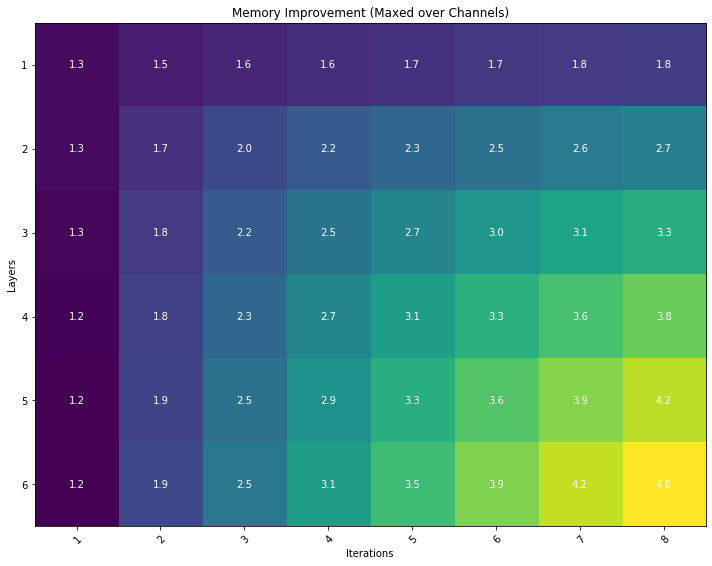

In [158]:
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(max_mem_ratio)

ax.set_xticklabels(np.arange(0, 9))
ax.set_yticklabels(np.arange(0, 8))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(layer_list)):
    for j in range(len(iteration_list)):
        text = ax.text(j, i, str('{:.1f}').format(max_mem_ratio[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Memory Improvement (Maxed over Channels)")
plt.xlabel("Iterations")
plt.ylabel("Layers")
fig.tight_layout()
plt.show()

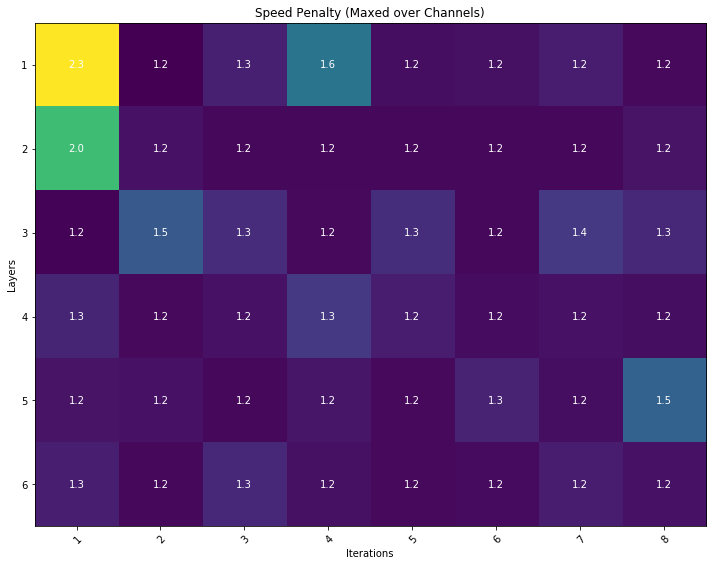

In [159]:
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(max_time_ratio)

ax.set_xticklabels(np.arange(0, 9))
ax.set_yticklabels(np.arange(0, 8))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(layer_list)):
    for j in range(len(iteration_list)):
        text = ax.text(j, i, str('{:.1f}').format(max_time_ratio[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Speed Penalty (Maxed over Channels)")
plt.xlabel("Iterations")
plt.ylabel("Layers")
fig.tight_layout()
plt.show()

### Regular Training

In [13]:
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_gnn(model, train_loader, optimizer, m_configs)
    print('Training loss: {:.4f} in time {}'.format(train_loss, tt() - tic))

    model.eval()
    with torch.no_grad():
        edge_pur, edge_eff, val_loss = evaluate_gnn(model, test_loader, m_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_pur": edge_pur, "edge_eff": edge_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'ResAGNN/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, edge_eff, edge_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 999.6741 in time 1369.7977874279022
Epoch: 0, Eff: 0.8926, Pur: 0.5942, Loss: 56.1014, LR: 0.001 in time 1403.7224946022034
Training loss: 965.6096 in time 1353.3591628074646
Epoch: 1, Eff: 0.8808, Pur: 0.5465, Loss: 64.1256, LR: 0.001 in time 1392.6192655563354


KeyboardInterrupt: 